In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import torch
from os.path import join
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

import sys 
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
from tensorboard_utils import extract_all_runs, extract_tensorboard_data_from_run, extract_last_step_summary, extract_last_K_step_avg_summary
from posthoc_analysis_utils import sweep_collect_eval_data, extract_rule_list_from_eval_col_Diffusion, format_rule_list_to_mat, visualize_indiv_rule_dynam, extract_and_convert, visualize_train_heldout_rule, extract_rule_list_from_eval_col
from circuit_toolkit.plot_utils import saveallforms
from stats_plot_utils import estimate_CI

In [3]:
tabdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Tables"
# figdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Figures_newrule"

GPT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"
DiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
SiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results"
SSM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Mamba_raven"
EDM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"

figroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning"
GPTfigdir = join(figroot, "GPT2_raven")
EDMfigdir = join(figroot, "EDM_raven")
DiTfigdir = join(figroot, "DiT_raven")
SiTfigdir = join(figroot, "SiT_raven")
SSMfigdir = join(figroot, "SSM_raven")
synopsisdir = join(figroot, "Figure_model_synopsis")

In [6]:
syndf_GPT = pd.read_csv(join(tabdir, "GPT_raven_tensorboard_data_last10_annotated.csv"), index_col=0)

In [8]:
syndf_GPT.query("joint_readout == True")

,Loss/train,Train/Avg_Loss,Val/AnyValid,Val/AnyValid_abinit,Val/Avg_Loss,Val/C2,Val/C2_abinit,Val/C3,Val/C3_abinit,lr,...,lr_std,joint_readout,embed_type,heldout,scale,dataset_size,uncond,Val/C23,Val/C23_abinit,readout_embed
run_name,,,,,,,,,,,,,,,,,,,,,
GPT2_base_joint_lm_cmb_emb_uncond_heldout0_stream0_16M,0.233769,0.560265,0.887250,0.888533,7.806574,0.48100,0.07075,0.51900,0.79630,1.037704e-07,...,5.678257e-08,True,cmb,True,GPT2-B,0.160,True,1.0,0.86705,cmb_emb-joint_lm
GPT2_base_joint_lm_joint_emb_uncond_heldout0_stream0_16M,0.240702,0.549686,0.863200,0.890250,7.871315,0.58395,0.08215,0.41605,0.78830,1.037704e-07,...,5.678257e-08,True,joint,True,GPT2-B,0.160,True,1.0,0.87045,joint_emb-joint_lm
GPT2_base_joint_lm_sep_emb_uncond_heldout0_stream0_016M,0.118319,0.141607,0.841583,0.999383,11.340110,0.88460,0.00070,0.11540,0.99820,1.037704e-07,...,5.678257e-08,True,sep,True,GPT2-B,0.016,True,1.0,0.99890,sep_emb-joint_lm
GPT2_base_joint_lm_sep_emb_uncond_heldout0_stream0_16M,0.227812,0.534217,0.884767,0.902683,7.886419,0.47180,0.05930,0.52820,0.83035,1.037704e-07,...,5.678257e-08,True,sep,True,GPT2-B,0.160,True,1.0,0.88965,sep_emb-joint_lm
GPT2_base_joint_lm_sep_emb_uncond_heldout0_stream16M,2.104376,2.136932,0.973433,0.988983,2.153408,0.17525,0.03035,0.82475,0.96615,1.037704e-07,...,5.678257e-08,True,sep,True,GPT2-B,16.000,True,1.0,0.99650,sep_emb-joint_lm
GPT2_base_joint_lm_sep_emb_uncond_heldout0_stream1_6M,1.952108,2.080739,0.988933,0.984617,2.320068,0.12500,0.05020,0.87500,0.94630,1.037704e-07,...,5.678257e-08,True,sep,True,GPT2-B,1.600,True,1.0,0.99650,sep_emb-joint_lm
GPT2_medium_joint_lm_cmb_emb_uncond_heldout0_stream0_16M,0.171093,NaN,0.885867,0.959583,9.098183,0.48460,0.01820,0.51540,0.92960,3.003088e-05,...,2.266023e-08,True,cmb,True,GPT2-M,0.160,True,1.0,0.94780,cmb_emb-joint_lm
GPT2_medium_joint_lm_joint_emb_uncond_heldout0_stream0_16M,0.170644,NaN,0.867750,0.958600,9.121909,0.54920,0.02215,0.45080,0.92520,2.962103e-05,...,1.418722e-08,True,joint,True,GPT2-M,0.160,True,1.0,0.94735,joint_emb-joint_lm
GPT2_medium_joint_lm_sep_emb_uncond_heldout0_stream0_16M,0.167905,NaN,0.898067,0.960767,9.080238,0.43270,0.01695,0.56730,0.93275,2.983070e-05,...,3.428309e-08,True,sep,True,GPT2-M,0.160,True,1.0,0.94970,sep_emb-joint_lm


In [14]:
syndf_GPT.loc["GPT2_base_joint_lm_sep_emb_uncond_heldout0_stream0_16M"].full_name

'GPT2_base_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200339/tensorboard_logs'

In [15]:
expname = "GPT2_base_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200339"
prefix = "eval_step" if "stream" in expname else "eval_epoch"
eval_col = sweep_collect_eval_data(expname, GPT_exproot, prefix=prefix)
epoch_list, rule_list_all_cont, consistency_all_cont = extract_rule_list_from_eval_col(eval_col, is_abinit=True)
rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all_cont, consistency_all_cont)
epoch_list, rule_list_all_cont_PC, consistency_all_cont_PC = extract_rule_list_from_eval_col(eval_col, is_abinit=False)
rule_cnt_mat_PC, cons3_rule_cnt_mat_PC, cons2_rule_cnt_mat_PC = format_rule_list_to_mat(rule_list_all_cont_PC, consistency_all_cont_PC)
eval_sample_num = rule_list_all_cont.shape[1]
if "heldout0" in expname:
    heldout_id = [1, 16, 20, 34, 37]  
else:
    heldout_id = []

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_base_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200339/samples
example file: eval_step704999.pt


  0%|          | 0/401 [00:00<?, ?it/s]

(401, 2000, 3) (401, 2, 2000)
(401, 2000, 3) (401, 2, 2000)


In [22]:
heldout_mask = np.zeros(40, dtype=bool)
heldout_mask[heldout_id] = True

In [21]:
cons3_rule_cnt_mat[-10:, :].sum(axis=0)

array([542.,   0., 598., 644., 586., 522., 536., 335., 368., 377., 597.,
       569., 567., 591., 596., 497.,   0., 350., 359., 377.,   0., 537.,
       609., 551., 546., 510., 499., 332., 349., 405., 416., 514., 476.,
       377.,   0., 418., 507.,   0., 278., 275.])

Text(0.5, 1.0, 'Panel Completion Accuracy\nTrain vs. Heldout\nGPT2_base_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200339')

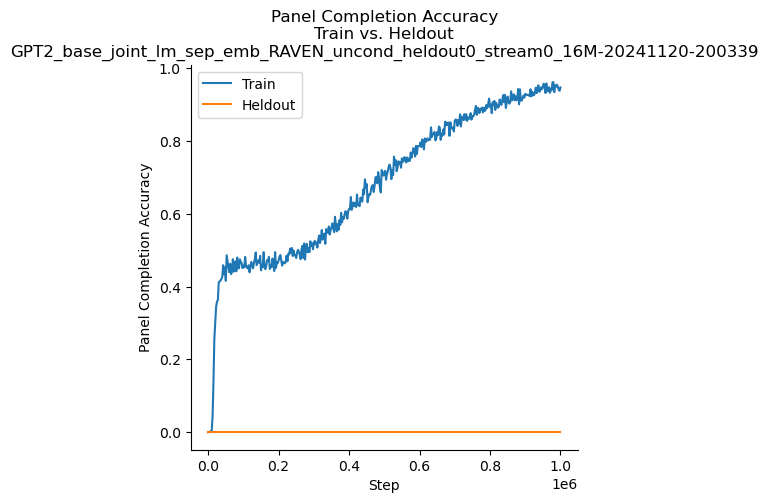

In [24]:
plt.figure(figsize=(5, 5))
plt.plot(epoch_list, cons3_rule_cnt_mat[:, ~heldout_mask].mean(axis=1) / eval_sample_num * 40, label="Train")
plt.plot(epoch_list, cons3_rule_cnt_mat[:, heldout_mask].mean(axis=1) / eval_sample_num * 40, label="Heldout")
plt.ylabel("Panel Completion Accuracy")
plt.xlabel("Step")
plt.legend()
plt.title(f"Panel Completion Accuracy\nTrain vs. Heldout\n{expname}")
# saveallforms(figsyndir, f"panel_compl_acc_learning_curve_train_heldout_split_{expname}")

Text(0.5, 1.0, 'Panel Completion Accuracy\nTrain vs. Heldout\nGPT2_base_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200339')

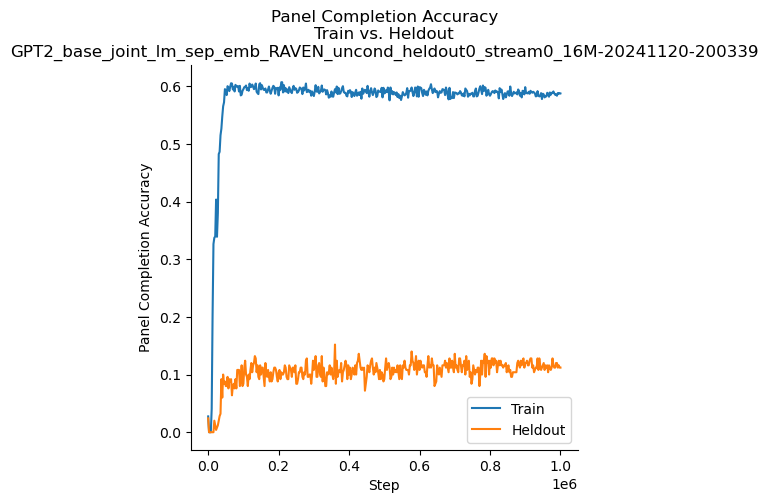

In [23]:
plt.figure(figsize=(5, 5))
plt.plot(epoch_list, cons3_rule_cnt_mat_PC[:, ~heldout_mask].mean(axis=1) / eval_sample_num * 40, label="Train")
plt.plot(epoch_list, cons3_rule_cnt_mat_PC[:, heldout_mask].mean(axis=1) / eval_sample_num * 40, label="Heldout")
plt.ylabel("Panel Completion Accuracy")
plt.xlabel("Step")
plt.legend()
plt.title(f"Panel Completion Accuracy\nTrain vs. Heldout\n{expname}")
# saveallforms(figsyndir, f"panel_compl_acc_learning_curve_train_heldout_split_{expname}")

In [27]:

from stats_plot_utils import add_rectangles, plot_rule_heatmap

Text(0.5, 1.0, 'ab init Generation Rule Frequency (C3 sample) [avg 0.831 train 0.949 heldout 0.000]\nGPT2_base_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200339')

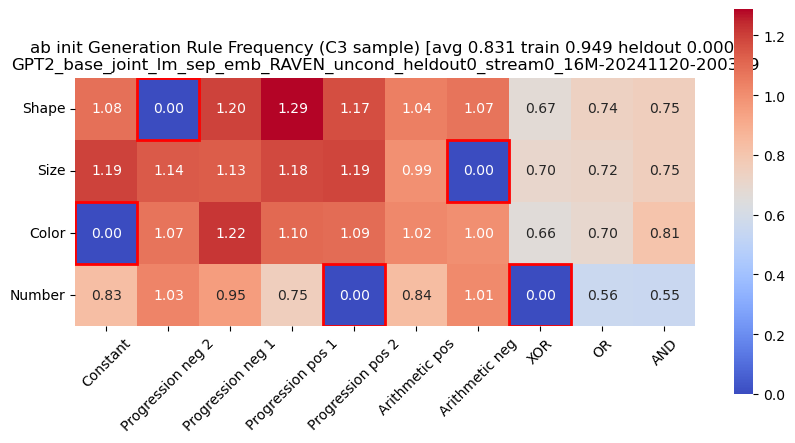

In [38]:
# plotinput = (accuracy_table[-5:,:].mean(axis=0))
plotmat = (cons3_rule_cnt_mat[-10:,:].mean(axis=0)).reshape(4, -1) / eval_sample_num * 40
plot_rule_heatmap(plotmat, heldout_rules=heldout_id, cmap="coolwarm")
heldout_avg = plotmat.flatten()[heldout_mask].mean()
train_avg = plotmat.flatten()[~heldout_mask].mean()
plt.title(f"ab init Generation Rule Frequency (C3 sample) [avg {plotmat.mean():.3f} train {train_avg:.3f} heldout {heldout_avg:.3f}]\n{expname}")
# saveallforms(figsyndir, f"{expname}_abinit_gen_acc_heatmap_C3sample", )

Text(0.5, 1.0, 'ab init Generation Rule Accuracy (valid row) per rule [avg 0.927 train 1.057 heldout 0.013]\nGPT2_base_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200339')

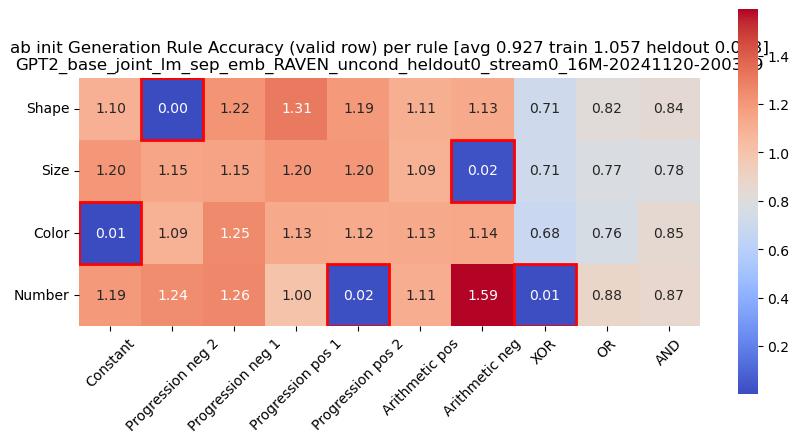

In [37]:
plotmat = (rule_cnt_mat[-10:,:].mean(axis=0)).reshape(4, -1) / eval_sample_num / 3 * 40 
plot_rule_heatmap(plotmat, heldout_rules=heldout_id, cmap="coolwarm")
heldout_avg = plotmat.flatten()[heldout_mask].mean()
train_avg = plotmat.flatten()[~heldout_mask].mean()
plt.title(f"ab init Generation Rule Accuracy (valid row) per rule [avg {plotmat.mean():.3f} train {train_avg:.3f} heldout {heldout_avg:.3f}]\n{expname}")
# saveallforms(figsyndir, f"{expname}_abinit_gen_acc_heatmap_validrow", )

In [34]:
epoch_num = rule_list_all_cont_PC.shape[0]
rule_num = 40
acc_cnt_table = np.zeros((epoch_num, rule_num))
accuracy_table = np.zeros((epoch_num, rule_num))
val_cnt_table = np.zeros((epoch_num, rule_num))
val_accuracy_table = np.zeros((epoch_num, rule_num))
mis_cnt_table = np.zeros((epoch_num, rule_num, rule_num))
for epochi in range(epoch_num):
    rule_list = rule_list_all_cont_PC[epochi]
    consistency_list = consistency_all_cont_PC[epochi]
    for rulei in range(rule_num):
        rule_mask = (rule_list[:,0]==np.array([rulei])) & (rule_list[:,1]==np.array([rulei]))
        C3_rules = consistency_list[0][rule_mask]
        C3_rules_flatten = sum(list(C3_rules), [])
        C3_cont_cnt = len(C3_rules_flatten)
        accuracy_table[epochi, rulei] = C3_cont_cnt / sum(rule_mask)
        acc_cnt_table[epochi, rulei] = C3_cont_cnt
        val_cnt_table[epochi, rulei] = sum(len(rule3) > 0 for rule3 in rule_list[rule_mask,-1])
        val_accuracy_table[epochi, rulei] = val_cnt_table[epochi, rulei] / sum(rule_mask)

Text(0.5, 1.0, 'Final Panel Completion Rule Accuracy (C3 sample) per rule [avg 0.528 train 0.587 heldout 0.116]\nGPT2_base_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200339')

<Figure size 800x600 with 0 Axes>

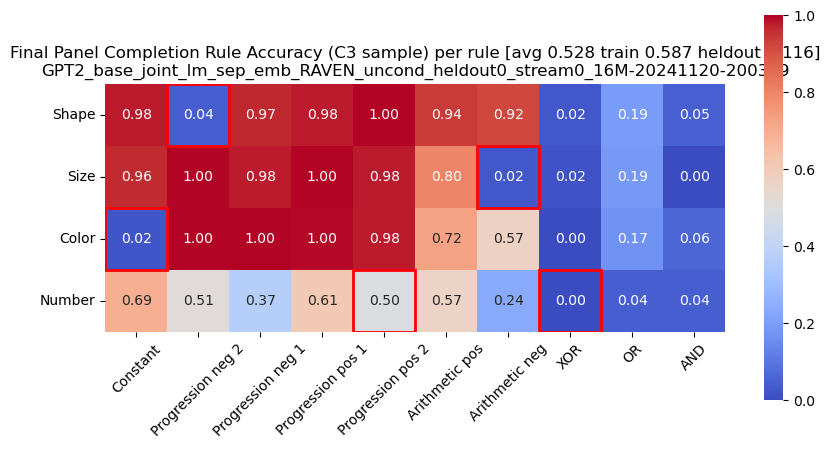

In [33]:
# plotinput = (accuracy_table[-5:,:].mean(axis=0))
plotmat = (cons3_rule_cnt_mat_PC[-10:,:].mean(axis=0)).reshape(4, -1) / eval_sample_num * 40
plt.figure(figsize=(8, 6))
plot_rule_heatmap(plotmat, heldout_rules=heldout_id, cmap="coolwarm")
heldout_avg = plotmat.flatten()[heldout_mask].mean()
train_avg = plotmat.flatten()[~heldout_mask].mean()
plt.title(f"Final Panel Completion Rule Accuracy (C3 sample) per rule [avg {plotmat.mean():.3f} train {train_avg:.3f} heldout {heldout_avg:.3f}]\n{expname}")
# saveallforms(figsyndir, f"{expname}_final_panel_compl_acc_heatmap_C3sample", )

Text(0.5, 1.0, 'Final Panel Completion Rule Accuracy (valid final row) per rule [avg 0.654 train 0.687 heldout 0.427]\nGPT2_base_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200339')

<Figure size 800x600 with 0 Axes>

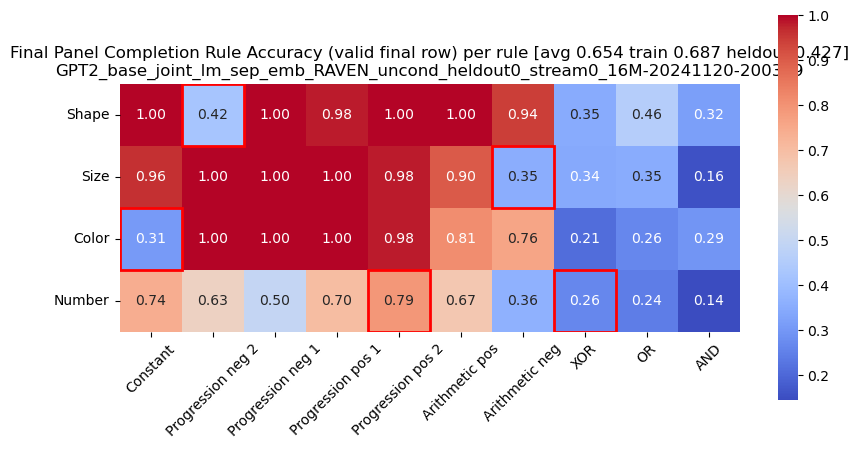

In [35]:
# plotinput = (accuracy_table[-5:,:].mean(axis=0))
# plotmat = (cons3_rule_cnt_mat_PC[-10:,:].mean(axis=0)).reshape(4, -1) / eval_sample_num * 40
plotmat = (val_accuracy_table[-10:,:].mean(axis=0)).reshape(4, -1)
plt.figure(figsize=(8, 6))
plot_rule_heatmap(plotmat, heldout_rules=heldout_id, cmap="coolwarm")
heldout_avg = plotmat.flatten()[heldout_mask].mean()
train_avg = plotmat.flatten()[~heldout_mask].mean()
plt.title(f"Final Panel Completion Rule Accuracy (valid final row) per rule [avg {plotmat.mean():.3f} train {train_avg:.3f} heldout {heldout_avg:.3f}]\n{expname}")
# saveallforms(figsyndir, f"{expname}_final_panel_compl_acc_heatmap_validrow", )